# Unsupervised attack

Допустим атакующая сторона имеет крайне мало таргета - в идеале, один клиент, которому точно не дают кредит.

Тогда атакующая сторона может выучить на своих транзакциях unsupervised модель, которая будет давать эмбеддинги. Транзакции для атаки выбирабтся таким образом: берем транзакции, которые уводят эмбеддинг на максимальное расстояние от исходного. Мы надеемся, что клиент при этом поменяет свой скор.

Отдельно откладывается отложенная выборка `test`, на которой происходит финальная проверка качества атаки.

Остальная часть рабивается на 5 фолдов, один из которых уходит на валадицию атаки, а остальные делятся на `target` и `substitute` части, в которых при необходимости могут выделяться еще `valid` для валидации атакующей или target моделей.

In [1]:
%cd ../

/mnt2/kireev/pycharm-deploy/pytorch-lifestream/experiments/scenario_gender


In [2]:
import sys
sys.path.append('../../')

In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "3"

In [4]:
import logging

In [5]:
from itertools import chain, islice, product, cycle

In [6]:
import matplotlib.pyplot as plt
import lightgbm
import numpy as np
import pandas as pd
import pickle
import pytorch_lightning as pl
import random
import torch

In [7]:
from copy import deepcopy
from tqdm.auto import tqdm
from pyhocon import ConfigFactory
from torch.utils.data import DataLoader
from sklearn.decomposition import PCA
from IPython.display import display

In [8]:
from sklearn.metrics import roc_auc_score, recall_score, precision_score

In [9]:
from embeddings_validation.tasks.report_collect import t_pm, t_int_l, t_int_h

In [10]:
from dltranz.data_load import padded_collate, IterableChain, IterableAugmentations
from dltranz.data_load.augmentations.build_augmentations import build_augmentations
from dltranz.data_load.data_module.map_augmentation_dataset import MapAugmentationDataset
from dltranz.data_load.iterable_processing.category_size_clip import CategorySizeClip
from dltranz.data_load.iterable_processing.feature_filter import FeatureFilter
from dltranz.data_load.iterable_processing.feature_type_cast import FeatureTypeCast
from dltranz.data_load.iterable_processing.seq_len_filter import SeqLenFilter
from dltranz.data_load.parquet_dataset import ParquetFiles, ParquetDataset
from dltranz.data_load.list_splitter import ListSplitter
from dltranz.data_load.iterable_processing.target_join import TargetJoin
from dltranz.data_load.iterable_processing.id_filter import IdFilter
from dltranz.data_load.iterable_processing_dataset import IterableProcessingDataset
from dltranz.models import create_head_layers
from dltranz.seq_encoder import create_encoder
from dltranz.seq_to_target import SequenceToTarget
from dltranz.train import score_model2
from dltranz.trx_encoder import PaddedBatch
from dltranz.util import get_cls

In [11]:
logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(levelname)-7s %(funcName)-20s   : %(message)s')

In [12]:
random.randint(1, 2**16)

61141

In [13]:
config_text = """
{
  seed_everything: 42

  data_module: {
      dataset_files: {
        train_data_path: "data/train_trx.parquet"
        test_data_path: "data/test_trx.parquet"
      }
      target_file_path: "data/gender_train.csv"
      
      col_id: customer_id
      col_id_dtype: int
      col_target: gender

      split_seed: 56424
      cv_folds: 5
      substitute_part: 0.5
  }
  
  substitute:
  {
      valid_ratio: 0.05
      train: {
          min_seq_len: 25
          split_strategy: {
            split_strategy: "SampleSlices"
            split_count: 5
            cnt_min: 15
            cnt_max: 75
          }
          trx_dropout: 0.01
          num_workers: 8
          batch_size: 128
      }
      valid: {
          split_strategy: {
            split_strategy: SampleSlices
            split_count: 5
            cnt_min: 25
            cnt_max: 100
          }
          num_workers: 16
          batch_size: 1024
      }

      logger_name: adv_substitute
      trainer: {
        gpus: 1
        auto_select_gpus: false

        # max_epochs: 100
        max_epochs: 100
        
        checkpoint_callback: false
        deterministic: True
      }
      params: {
        validation_metric_params: {
          K: 4
          metric: cosine
        }
        
        encoder_type: rnn,
        trx_encoder: {
          norm_embeddings: false,
          embeddings_noise: 0.003,
          embeddings: {
            mcc_code: {in: 200, out: 48},
            tr_type: {in: 100, out: 24}
          },
          numeric_values: {
            amount: identity
          }
        },
        rnn: {
          # hidden_size: 512,
          hidden_size: 64
          type: gru,
          bidir: false,
          trainable_starter: static
        },

        head_layers: [
            [NormEncoder, {}],
        ]

        train: {
          sampling_strategy: HardNegativePair,
          neg_count: 5,
          loss: ContrastiveLoss,
          margin: 0.5,
          lr: 0.002,
          weight_decay: 0.0
        },
        lr_scheduler: {
          step_size: 10,
          step_gamma: 0.9025
        }
      }
  }
  
  attack: {
      mcc_len: 2
      max_mcc: 70
      # sample_rate: 0.1
      sample_rate: 0.1

      augmentations: [
        [SeqLenLimit, {max_seq_len: 1200}]
      ]
      num_workers: 0
      batch_size: 500
  }
  
  agg_target: {
    params: {
        encoder_type: agg_features
        trx_encoder: {
          embeddings: {
            mcc_code: {in: 200}
            tr_type: {in: 100}
          }
          numeric_values: {
            amount: identity
          }
          was_logified: true
          log_scale_factor: 1
        }
    }
  }
  coles_target: {
        trainer: {
            # max_epochs: 150
            # max_epochs: 5
            max_epochs: 100
        }
        train: {
          min_seq_len: 25
          split_strategy: {
            split_strategy: "SampleSlices"
            split_count: 5
            cnt_min: 15
            cnt_max: 75
          }
          trx_dropout: 0.01
          num_workers: 8
          batch_size: 128
        }
        valid: {
          split_strategy: {
            split_strategy: SampleSlices
            split_count: 5
            cnt_min: 25
            cnt_max: 100
          }
          num_workers: 16
          batch_size: 1024
        }
      params: {
            validation_metric_params: {
                K: 4
                metric: cosine
            }

            encoder_type: rnn,
            trx_encoder: {
              norm_embeddings: false,
              embeddings_noise: 0.003,
              embeddings: {
                mcc_code: {in: 200, out: 48},
                tr_type: {in: 100, out: 24}
              },
              numeric_values: {
                amount: identity
              }
            },
            rnn: {
              type: gru,
              hidden_size: 512,
              bidir: false,
              trainable_starter: static
            },
            head_layers: [
                [NormEncoder, {}],
            ]

            lr_scheduler: {
              step_size: 10,
              step_gamma: 0.9025
            },
            train: {
              sampling_strategy: HardNegativePair,
              neg_count: 5,
              loss: ContrastiveLoss,
              margin: 0.5,
              lr: 0.002,
              weight_decay: 0.0
            }
      }
  }
  target_rnn: {
      trainer: {
        gpus: 1
        auto_select_gpus: false

        # max_epochs: 50
        max_epochs: 25
        
        deterministic: True
      }
      params: {
        score_metric: [auroc, accuracy]

        encoder_type: rnn,
        trx_encoder: {
          norm_embeddings: false,
          embeddings_noise: 0.003,
          embeddings: {
            mcc_code: {in: 200, out: 48},
            tr_type: {in: 100, out: 24}
          },
          numeric_values: {
            amount: identity
          }
        },
        rnn: {
          hidden_size: 48,
          type: gru,
          bidir: false,
          trainable_starter: static
        },

        head_layers: [
            [BatchNorm1d, {num_features: "{seq_encoder.embedding_size}"}]
            [Linear, {"in_features": "{seq_encoder.embedding_size}", "out_features": 1}]
            [Sigmoid, {}]
            [Squeeze, {}]
        ]

        train: {
          random_neg: false,
          loss: bce,
          lr: 0.005,
          weight_decay: 0.0,
        },
        lr_scheduler: {
          step_size: 1,
          step_gamma: 0.70
        }
      }
  }
  lgbm_params: {
        n_estimators: 500
        boosting_type: gbdt
        objective: binary
        metric: auc
        subsample: 0.5
        subsample_freq: 1
        learning_rate: 0.02
        feature_fraction: 0.75
        max_depth: 6
        lambda_l1: 1
        lambda_l2: 1
        min_data_in_leaf: 50
        random_state: 42
        n_jobs: 8
        reg_alpha: null
        reg_lambda: null
        colsample_bytree: null
        min_child_samples: null
  }

}
"""

conf = ConfigFactory.parse_string(config_text)

In [14]:
from adversarial_tools import (
    TargetToDict,
    PretrainedAttack,
    Adversarial4PartSplitter,
    AdversarialAttackDataModule,
)

In [15]:
from adversarial_tools import (
    train_coles_model,
    get_mcc_freq,
)

In [16]:
def get_dataset(conf, seq_encoder, files, apply_attacks=[]):
    # load_target
    col_id = conf['data_module.col_id']
    col_id_dtype = {
        'str': str,
        'int': int,
    }[conf['data_module.col_id_dtype']]
    col_target = conf['data_module.col_target']
    y_cast = int
    
    df = pd.read_csv(conf['data_module.target_file_path'])
    df[col_id] = df[col_id].astype(col_id_dtype)
    df[col_target] = df[col_target].astype(y_cast)
    _targets = df.set_index(col_id)[col_target].to_dict()
    
    category_names = seq_encoder.category_names
    category_names.add('event_time')

    dataset = ParquetDataset(
        files,
        post_processing=IterableChain(
            FeatureTypeCast({col_id: col_id_dtype}),
            IdFilter(id_col=col_id, relevant_ids=list(_targets.keys())),
            TargetJoin(col_id, _targets, y_cast),
            TargetToDict(col_id),
            *apply_attacks,
            FeatureFilter(keep_feature_names=category_names),
            CategorySizeClip(seq_encoder.category_max_size),
            IterableAugmentations(build_augmentations(conf['attack.augmentations'])),
        ),
        shuffle_files=False,
    )

    return dataset

In [17]:
def estimate_data(embedding_model, cls_model, files, pretrained_attacks):
    # orig
    dataloader = DataLoader(
        dataset=get_dataset(conf, embedding_model, files),
        collate_fn=padded_collate,
        shuffle=False,
        num_workers=conf['attack.num_workers'],
        batch_size=conf['attack.batch_size'],
        drop_last=False,
    )
    X, y = score_model2(embedding_model, dataloader, {'device': 'cuda'})
    y = np.array([e['y'] for e in y])
    orig_scores = cls_model.predict_proba(X)[:, 1]
    yield 'auroc_orig', roc_auc_score(y, orig_scores)
    yield 'recall_orig', recall_score(y, orig_scores > 0.5)
    yield 'precision_orig', precision_score(y, orig_scores > 0.5)

    p_a = [PretrainedAttack(conf['data_module.col_id'], pretrained_attacks)]
    dataloader = DataLoader(
        dataset=get_dataset(conf, embedding_model, files, p_a),
        collate_fn=padded_collate,
        shuffle=False,
        num_workers=conf['attack.num_workers'],
        batch_size=conf['attack.batch_size'],
        drop_last=False,
    )
    X, y = score_model2(embedding_model, dataloader, {'device': 'cuda'})
    y = np.array([e['y'] for e in y])
    att_scores = cls_model.predict_proba(X)[:, 1]
    yield 'auroc_adv',  roc_auc_score(y, att_scores)
    yield 'recall_adv', recall_score(y, att_scores > 0.5)
    yield 'precision_adv', precision_score(y, att_scores > 0.5)

    yield 'p_drop', (orig_scores - att_scores).mean()
    
    yield 'p_drop_1', (orig_scores - att_scores)[y == 1].mean()
    yield 'p_drop_0', (orig_scores - att_scores)[y == 0].mean()
    yield 'p_drop_1a', ((orig_scores - att_scores)[y == 1] > 0).mean()
    yield 'p_drop_0a', ((orig_scores - att_scores)[y == 0] > 0).mean()
    plt.show()

In [18]:
def train_target_model_agg_feature(fold_id, fold, pretrained_attacks):        
    target_model = create_encoder(conf['agg_target.params'], is_reduce_sequence=True)
    train_dataloader = DataLoader(
        dataset=get_dataset(conf, target_model, fold['target']),
        collate_fn=padded_collate,
        shuffle=False,
        num_workers=conf['attack.num_workers'],
        batch_size=conf['attack.batch_size'],
        drop_last=False,
    )
    train_X, train_y = score_model2(target_model, train_dataloader, {'device': 'cuda'})
    train_y = np.array([e['y'] for e in train_y])
    lgb_cls = lightgbm.LGBMClassifier(**conf['lgbm_params'])
    lgb_cls.fit(train_X, train_y)
    
    for fields in estimate_data(target_model, lgb_cls, files=fold['valid'],
                                pretrained_attacks=pretrained_attacks):
        yield 'agg_features', 'lgb_cls', 'valid', *fields
    for fields in estimate_data(target_model, lgb_cls, files=fold['test'],
                                pretrained_attacks=pretrained_attacks):
        yield 'agg_features', 'lgb_cls', 'test', *fields

# Run

In [19]:
if 'seed_everything' in conf:
    pl.seed_everything(conf['seed_everything'])

Global seed set to 42


In [20]:
data_splitter = Adversarial4PartSplitter(conf['data_module'])

In [21]:
results = []
for fold_id, fold in data_splitter.folds.items():
    if fold_id != 0:
        continue
    
    substitute_model = train_coles_model(fold_id, fold['substitute'], conf['substitute'])
    mcc_freq = get_mcc_freq(fold['substitute'], substitute_model)
    
    attack_dm = AdversarialAttackDataModule(
        conf, substitute_model, mcc_freq, fold['valid'] + fold['test'])
    attack_dm.prepare_data()
    
    logger.info('Calculate attacks')
    test_embeddings, original_scores = tuple(
        score_model2(substitute_model, attack_dm.test_dataloader(), {'device': 'cuda'}))
    pd_scores = pd.DataFrame(original_scores.tolist())
    
    # select maximum embedding shift
    rev_ix = pd_scores[pd_scores['new_trx_len'].eq(0)]['id'].reset_index(drop=True).reset_index().set_index('id')
    original_embeddings = test_embeddings[pd_scores['new_trx_len'].eq(0).values]
    original_embeddings = original_embeddings[rev_ix.loc[pd_scores['id'].values]['index'].values]
    pd_scores['dist'] = np.power(np.power(test_embeddings - original_embeddings, 2).sum(axis=1), 0.5)

    adv_sequences = pd_scores[lambda x: x['new_trx_len'].ne(0)] \
        .groupby('id').apply(lambda x: x.sort_values('dist', ascending=False).iloc[0]).set_index('id') \
        .drop(columns='y').to_dict(orient='index')
    
    pa = {k: v['new_trx'] for k, v in adv_sequences.items()}
#     for fields in train_target_model_rnn(fold_id, fold, pa):
#         print(f'[{fold_id}]: {fields}')
#         results.append(fields)
        
#     for fields in train_target_model_coles(fold_id, fold, pa):
#         print(f'[{fold_id}]: {fields}')
#         results.append(fields)

    for fields in train_target_model_agg_feature(fold_id, fold, pa):
        print(f'[{fold_id}]: {fields}')
        results.append(fields)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
2021-07-05 12:32:31,445 INFO    get_lr_scheduler       : StepLR lr_scheduler used

  | Name               | Type             | Params
--------------------------------------------------------
0 | _seq_encoder       | RnnSeqEncoder    | 38.8 K
1 | _validation_metric | BatchRecallTopPL | 0     
2 | _head              | Sequential       | 0     
--------------------------------------------------------
38.8 K    Trainable params
0         Non-trainable params
38.8 K    Total params
0.155     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

2021-07-05 12:37:56,283 INFO    <module>               : Calculate attacks
1it [00:00,  6.16it/s]   

[0]: ('agg_features', 'lgb_cls', 'valid', 'auroc_orig', 0.8630378639986986)
[0]: ('agg_features', 'lgb_cls', 'valid', 'recall_orig', 0.6764275256222547)
[0]: ('agg_features', 'lgb_cls', 'valid', 'precision_orig', 0.7804054054054054)


1it [00:00,  6.47it/s]

[0]: ('agg_features', 'lgb_cls', 'valid', 'auroc_adv', 0.8499572962420693)
[0]: ('agg_features', 'lgb_cls', 'valid', 'recall_adv', 0.739385065885798)
[0]: ('agg_features', 'lgb_cls', 'valid', 'precision_adv', 0.7276657060518732)
[0]: ('agg_features', 'lgb_cls', 'valid', 'p_drop', -0.040547774628596066)
[0]: ('agg_features', 'lgb_cls', 'valid', 'p_drop_1', -0.030524491405238312)
[0]: ('agg_features', 'lgb_cls', 'valid', 'p_drop_0', -0.04847127282483837)
[0]: ('agg_features', 'lgb_cls', 'valid', 'p_drop_1a', 0.3235724743777452)
[0]: ('agg_features', 'lgb_cls', 'valid', 'p_drop_0a', 0.21643518518518517)


0it [00:00, ?it/s]    

[0]: ('agg_features', 'lgb_cls', 'test', 'auroc_orig', 0.8557795178803124)
[0]: ('agg_features', 'lgb_cls', 'test', 'recall_orig', 0.682741116751269)
[0]: ('agg_features', 'lgb_cls', 'test', 'precision_orig', 0.8029850746268656)


[0]: ('agg_features', 'lgb_cls', 'test', 'auroc_adv', 0.8491611845849172)
[0]: ('agg_features', 'lgb_cls', 'test', 'recall_adv', 0.733502538071066)
[0]: ('agg_features', 'lgb_cls', 'test', 'precision_adv', 0.7585301837270341)
[0]: ('agg_features', 'lgb_cls', 'test', 'p_drop', -0.04621107509413483)
[0]: ('agg_features', 'lgb_cls', 'test', 'p_drop_1', -0.039090590684786965)
[0]: ('agg_features', 'lgb_cls', 'test', 'p_drop_0', -0.052501368496114774)
[0]: ('agg_features', 'lgb_cls', 'test', 'p_drop_1a', 0.2639593908629442)
[0]: ('agg_features', 'lgb_cls', 'test', 'p_drop_0a', 0.19955156950672645)


In [22]:
fold_id, fold = 0,  data_splitter.folds[0]

In [25]:
def get_subst_embedding(model, files):
    dataloader = DataLoader(
        dataset=get_dataset(conf, model, files),
        collate_fn=padded_collate,
        shuffle=False,
        num_workers=conf['attack.num_workers'],
        batch_size=conf['attack.batch_size'],
        drop_last=False,
    )
    embeddings, y = score_model2(model, dataloader, {'device': 'cuda'})
    return embeddings, y

In [26]:
substitute_embedding, substitute_y = get_subst_embedding(substitute_model, fold['substitute'])
substitute_y = np.array([y['y'] for y in substitute_y])

In [27]:
substitute_y

array([0, 0, 1, ..., 0, 0, 0])

In [28]:
len(rev_ix)

2387

In [34]:
neg_subst_ix = np.random.choice(np.where(substitute_y == 0)[0], 512 * len(rev_ix)).reshape(len(rev_ix), -1)
pos_subst_ix = np.random.choice(np.where(substitute_y == 1)[0], 512 * len(rev_ix)).reshape(len(rev_ix), -1)

In [35]:
original_embeddings = test_embeddings[pd_scores['new_trx_len'].eq(0).values]
original_embeddings = original_embeddings[rev_ix.loc[pd_scores['id'].values]['index'].values]

# chose maximum distance
pd_scores['dist'] = np.power(np.power(test_embeddings - original_embeddings, 2).sum(axis=1), 0.5)

for i in tqdm(range(512)):
    v = substitute_embedding[pos_subst_ix[:, i]][rev_ix.loc[pd_scores['id'].values]['index'].values]
    pd_scores['dist'] += np.power(np.power(test_embeddings - v, 2).sum(axis=1), 0.5)
    v = substitute_embedding[neg_subst_ix[:, i]][rev_ix.loc[pd_scores['id'].values]['index'].values]
    pd_scores['dist'] = -np.power(np.power(test_embeddings - v, 2).sum(axis=1), 0.5)

  0%|          | 0/512 [00:00<?, ?it/s]

In [36]:
adv_sequences = pd_scores[lambda x: x['new_trx_len'].ne(0)] \
    .groupby('id').apply(lambda x: x.sort_values('dist', ascending=False).iloc[0]).set_index('id') \
    .drop(columns='y').to_dict(orient='index')

pa = {k: v['new_trx'] for k, v in adv_sequences.items()}

In [37]:
for fields in train_target_model_agg_feature(fold_id, fold, pa):
    print(f'[{fold_id}]: {fields}')

1it [00:00,  5.78it/s]

[0]: ('agg_features', 'lgb_cls', 'valid', 'auroc_orig', 0.8630378639986986)
[0]: ('agg_features', 'lgb_cls', 'valid', 'recall_orig', 0.6764275256222547)
[0]: ('agg_features', 'lgb_cls', 'valid', 'precision_orig', 0.7804054054054054)


1it [00:00,  6.40it/s]

[0]: ('agg_features', 'lgb_cls', 'valid', 'auroc_adv', 0.8584963532346401)
[0]: ('agg_features', 'lgb_cls', 'valid', 'recall_adv', 0.6822840409956076)
[0]: ('agg_features', 'lgb_cls', 'valid', 'precision_adv', 0.7702479338842976)
[0]: ('agg_features', 'lgb_cls', 'valid', 'p_drop', 0.0005447705238400304)
[0]: ('agg_features', 'lgb_cls', 'valid', 'p_drop_1', 0.0049020944661197505)
[0]: ('agg_features', 'lgb_cls', 'valid', 'p_drop_0', -0.0028997343981241475)
[0]: ('agg_features', 'lgb_cls', 'valid', 'p_drop_1a', 0.5812591508052709)
[0]: ('agg_features', 'lgb_cls', 'valid', 'p_drop_0a', 0.4710648148148148)


0it [00:00, ?it/s]    

[0]: ('agg_features', 'lgb_cls', 'test', 'auroc_orig', 0.8557795178803124)
[0]: ('agg_features', 'lgb_cls', 'test', 'recall_orig', 0.682741116751269)
[0]: ('agg_features', 'lgb_cls', 'test', 'precision_orig', 0.8029850746268656)


[0]: ('agg_features', 'lgb_cls', 'test', 'auroc_adv', 0.8482905010129521)
[0]: ('agg_features', 'lgb_cls', 'test', 'recall_adv', 0.6903553299492385)
[0]: ('agg_features', 'lgb_cls', 'test', 'precision_adv', 0.8192771084337349)
[0]: ('agg_features', 'lgb_cls', 'test', 'p_drop', 0.003016650190465443)
[0]: ('agg_features', 'lgb_cls', 'test', 'p_drop_1', 0.008561622039244501)
[0]: ('agg_features', 'lgb_cls', 'test', 'p_drop_0', -0.001881822698366283)
[0]: ('agg_features', 'lgb_cls', 'test', 'p_drop_1a', 0.6040609137055838)
[0]: ('agg_features', 'lgb_cls', 'test', 'p_drop_0a', 0.47533632286995514)


In [38]:
# pca на облаке эмбеддингов с таргетом

In [53]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

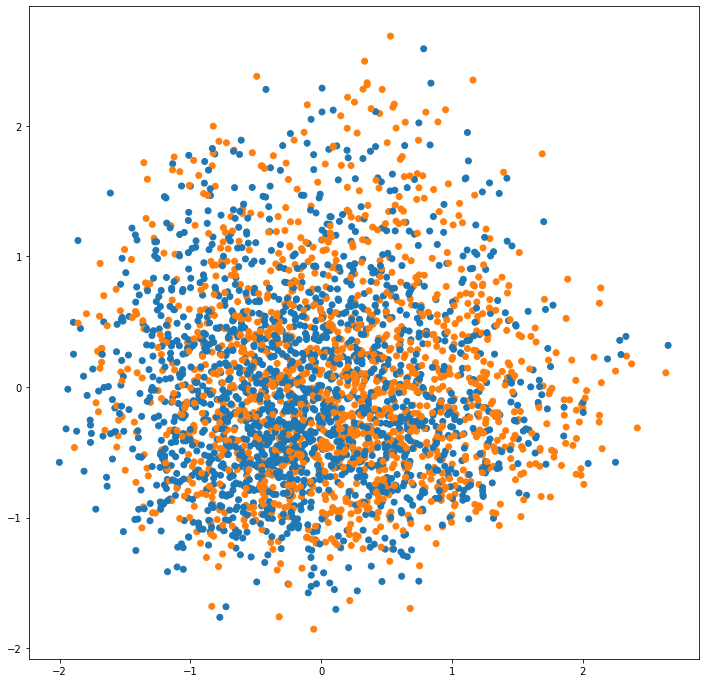

In [76]:
pca = PCA(2)
pca_emb = pca.fit_transform(substitute_embedding)
plt.figure(figsize=(12, 12))
plt.scatter(pca_emb[:, 0], pca_emb[:, 1], c=[plt.get_cmap('tab10')(i) for i in substitute_y])
plt.show()

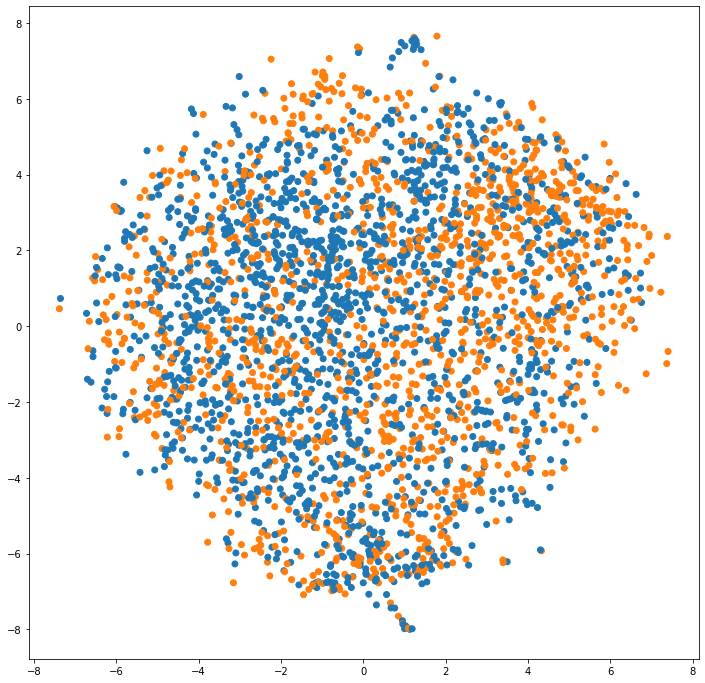

In [55]:
tsne = TSNE(2, perplexity=300)
tsne_emb = tsne.fit_transform(substitute_embedding)
plt.figure(figsize=(12, 12))
plt.scatter(tsne_emb[:, 0], tsne_emb[:, 1], c=[plt.get_cmap('tab10')(i) for i in substitute_y])
plt.show()

In [60]:
from sklearn.linear_model import Ridge
from sklearn.metrics import roc_auc_score

In [57]:
cls = Ridge()

In [73]:
cls.fit(substitute_embedding[:16], substitute_y[:16])

Ridge()

In [74]:
roc_auc_score(substitute_y[128:], cls.predict(substitute_embedding[128:]))

0.6516424976141999

In [ ]:
pd.DataFrame(results, columns=['encoder', 'target_model', 'set', 'metric', 'value']) \
    .pivot_table(index=['encoder', 'target_model', 'metric'],
                 columns='set', values='value', aggfunc=['mean', t_pm, t_int_l, t_int_h, 'count']) \
    .swaplevel(axis=1)[['valid', 'test']].round(3)

In [ ]:
print(pd.DataFrame(results, columns=['encoder', 'target_model', 'set', 'metric', 'value']) \
    .pivot_table(index=['encoder', 'target_model', 'metric'],
                 columns='set', values='value', aggfunc=['mean', t_pm, t_int_l, t_int_h, 'count']) \
    .swaplevel(axis=1)[['valid', 'test']].round(3).to_markdown())